In [10]:
import sys
sys.path.insert(0, '../../wildlife-tools')
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import pandas as pd
import torchvision.transforms as T
import timm

from wildlife_datasets import datasets
from wildlife_tools.data import WildlifeDataset
from wildlife_tools.features import DeepFeatures
from wildlife_tools.similarity import CosineSimilarity
from wildlife_tools.inference import KnnClassifier

import os
sys.path.append('..')
import pandas as pd
from wildlife_datasets import datasets, loader, analysis
from wildlife_datasets.analysis import display_statistics, plot_bbox_segmentation, plot_grid
from wildlife_datasets.splits import visualize_split
from wildlife_datasets.splits import TimeCutoffSplit, TimeProportionSplit


In [11]:
# #Loading the dataset

# datasets = loader.load_datasets(
#     [
#     datasets.AAUZebraFish,
#     datasets.AerialCattle2017,
#     datasets.ATRW,
#     datasets.BelugaID,
#     datasets.BirdIndividualID,
#     datasets.BirdIndividualIDSegmented,
#     datasets.CatIndividualImages,
#     datasets.CTai,
#     datasets.CZoo,
#     datasets.CowDataset,
#     datasets.Cows2021v2,
#     datasets.DogFaceNet,
#     datasets.Drosophila,
#     datasets.FriesianCattle2015v2,
#     datasets.FriesianCattle2017,
#     datasets.GiraffeZebraID,
#     datasets.Giraffes,
#     datasets.GreenSeaTurtles,
#     datasets.HappyWhale,
#     datasets.HumpbackWhaleID,
#     datasets.HyenaID2022,
#     datasets.IPanda50,
#     datasets.LeopardID2022,
#     datasets.LionData,
#     datasets.MacaqueFaces,
#     datasets.MPDD,
#     datasets.NDD20v2,
#     datasets.NOAARightWhale,
#     datasets.NyalaData,
#     datasets.OpenCows2020,
#     datasets.PolarBearVidID,
#     datasets.SealID,
#     datasets.SealIDSegmented,
#     datasets.SeaStarReID2023,
#     datasets.SeaTurtleID2022,
#     datasets.SeaTurtleIDHeads,
#     datasets.SMALST,
#     datasets.StripeSpotter,
#     datasets.WhaleSharkID,
#     datasets.ZindiTurtleRecall
# ]
# ,
#     'data',
#     'dataframes'
# )

In [12]:
#Loading the dataset

names = [
    datasets.LionData,
    datasets.SealIDSegmented,
    datasets.SeaStarReID2023,
    datasets.StripeSpotter,
    datasets.CTai,
    datasets.CZoo,
    datasets.NyalaData,
    datasets.SeaTurtleID2022
]

In [13]:
l = [
 'datasets.LionData',
 'datasets.SealIDSegmented',
 'datasets.SeaStarReID2023',
 'datasets.StripeSpotter',
 'datasets.CTai',
 'datasets.CZoo',
 'datasets.NyalaData',
 'datasets.SeaTurtleID2022']

In [14]:
roots = ['data/' + str(dataset).split('.')[1] for dataset in l]
roots

['data/LionData',
 'data/SealIDSegmented',
 'data/SeaStarReID2023',
 'data/StripeSpotter',
 'data/CTai',
 'data/CZoo',
 'data/NyalaData',
 'data/SeaTurtleID2022']

Analysis and Visual Reidentification using MegaDescriptor

data/SeaTurtleID2022


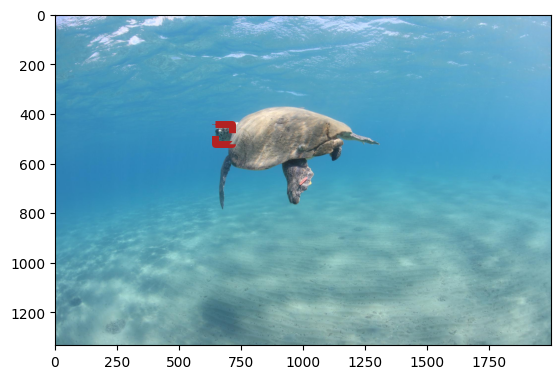

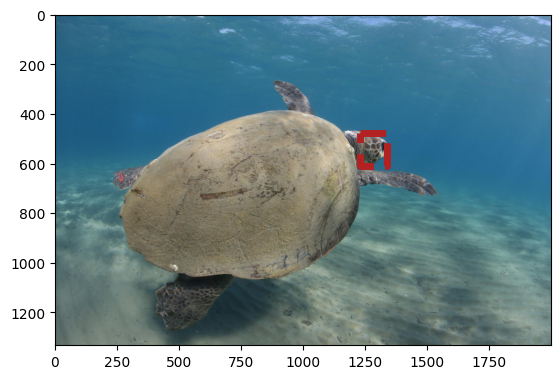

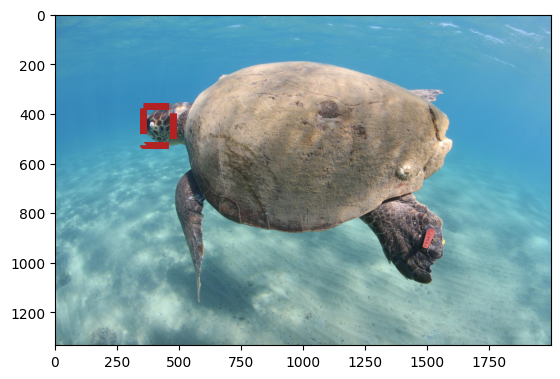

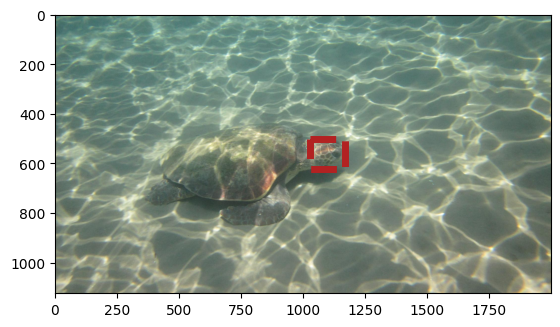

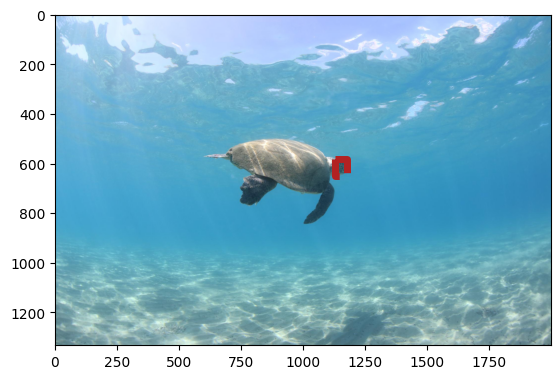

In [15]:
root = roots[7]
print(root)
m = names[7](root)
print(m)
df = m.df
plot_bbox_segmentation(df, root, 5)

In [16]:
transform = T.Compose([T.Resize([224, 224]), T.ToTensor(), T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))])
dataset_database = WildlifeDataset(df.iloc[100:,:], root, transform=transform)
dataset_query = WildlifeDataset(df.iloc[:100,:], root, transform=transform)

In [17]:
from wildlife_tools.features import DeepFeatures

name = 'hf-hub:BVRA/MegaDescriptor-T-224'
extractor = DeepFeatures(timm.create_model(name, num_classes=0, pretrained=True))

In [18]:
# Assuming df contains your entire dataset
dataset = WildlifeDataset(df, root, transform=transform)

# Extracting the query instances and database instances
dataset_query = WildlifeDataset(df.iloc[:100, :], root, transform=transform)
dataset_database = WildlifeDataset(df.iloc[100:, :], root, transform=transform)

query_features, database_features = extractor(dataset_query), extractor(dataset_database)

  0%|                                                                         | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████████████████████████████| 68/68 [22:07<00:00, 19.53s/it]


In [19]:
print(f'Query features shape: {query_features.shape}, Database features shape: {database_features.shape}')

Query features shape: (100, 768), Database features shape: (8629, 768)


In [20]:
import numpy as np
from wildlife_tools.similarity import CosineSimilarity

# Cosine similarity between deep features
similarity = CosineSimilarity()
sim = similarity(query_features, database_features)['cosine']
print("Similarity matrix: \n", sim.shape)

Similarity matrix: 
 (100, 8629)


In [21]:
# classifier = KnnClassifier(k=1, database_labels=dataset_database.labels_string)
# predictions = classifier(similarity['cosine'])

# Nearest neigbour classifier using the similarity
classifier = KnnClassifier(k=1, database_labels=dataset_database.labels_string)
preds = classifier(sim)
print(type(preds))
print("Prediction \t", preds)
print("Ground truth \t", dataset_query.labels_string)



<class 'numpy.ndarray'>
Prediction 	 ['t092' 't200' 't102' 't451' 't087' 't230' 't014' 't316' 't567' 't459'
 't035' 't119' 't011' 't200' 't056' 't099' 't075' 't459' 't084' 't175'
 't238' 't043' 't295' 't063' 't007' 't007' 't057' 't007' 't276' 't058'
 't007' 't017' 't295' 't063' 't006' 't033' 't385' 't016' 't018' 't014'
 't163' 't518' 't033' 't094' 't048' 't076' 't008' 't068' 't070' 't094'
 't007' 't296' 't068' 't045' 't063' 't051' 't076' 't042' 't021' 't174'
 't007' 't084' 't344' 't296' 't372' 't009' 't203' 't065' 't386' 't004'
 't004' 't250' 't016' 't296' 't265' 't004' 't035' 't008' 't015' 't315'
 't021' 't215' 't074' 't004' 't004' 't058' 't306' 't364' 't024' 't398'
 't008' 't202' 't004' 't468' 't004' 't004' 't261' 't004' 't026' 't048']
Ground truth 	 ['t001' 't001' 't001' 't001' 't001' 't001' 't001' 't001' 't001' 't001'
 't001' 't001' 't001' 't001' 't001' 't001' 't001' 't001' 't001' 't001'
 't001' 't001' 't002' 't002' 't002' 't002' 't002' 't002' 't002' 't002'
 't002' 't002' 't002' 't

d:\Classroom\Project\p1\wildlife-datasets\..\wildlife_tools\inference\classifier.py:61: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  results = pd.DataFrame(results).T.fillna(method="ffill").T


In [22]:
# Importing metrics
from wildlife_datasets.metrics import accuracy, balanced_accuracy, precision, recall, f1

# Assuming y_true and y_pred are your true labels and predictions respectively
y_true = dataset_query.labels_string  # True labels
y_pred = preds  # Predicted labels

# Computing evaluation metrics
acc = accuracy(y_true, y_pred)
bal_acc = balanced_accuracy(y_true, y_pred)
prec = precision(y_true, y_pred)
rec = recall(y_true, y_pred)
f1_score = f1(y_true, y_pred)

# Printing the computed metrics
print("Accuracy:", acc)
print("Balanced Accuracy:", bal_acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1_score)

Accuracy: 0.09
Balanced Accuracy: 0.054878048780487805
Precision: 0.014285714285714285
Recall: 0.0031358885017421603
F1 Score: 0.005142857142857143


c:\Users\HP\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\HP\scoop\apps\python\current\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
